## Helio Inaba - CQF June 2023 Final Project 
## Optimal Hedging with Advanced Delta Modelling

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import scipy
from scipy.stats import norm
from scipy.optimize import minimize


from datetime import datetime
import os

#pd.set_option('display.max_columns', None)
pd.reset_option('^display.', silent=True)


#### Defining Functions

In [2]:
def gaussian(data, bins):
    
    return 1/(data.std()*np.sqrt(2*np.pi))*(np.exp(-(bins - data.mean())**2/(2*data.std()**2)))


def black_scholes(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d1 = norm.cdf(d1)
    n_d2 = norm.cdf(d2)

    V = n_d1*S-n_d2*K*np.exp(-r*T)
    
    return V


def bs_delta(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    n_d1 = norm.cdf(d1)
    
    return n_d1


def bs_gamma(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))


def bs_vega(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return S*norm.pdf(d1)*np.sqrt(T)


def bs_theta(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    theta = -S*norm.pdf(d1)*sigma/(2*np.sqrt(T))
    theta -= r*K*np.exp(-r*T)*n_d2

    return theta

def bs_rho(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    return K*T*np.exp(-r*T)*n_d2


def euler_maruyama(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_periods, n_simulations))
    prices[0] = s0

    for i in range(1, n_periods):

        prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*np.random.normal(loc=0.0, scale=1.0, size=n_simulations))

    prices = pd.DataFrame(prices)
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def milstein(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_simulations, n_periods+1))
    prices[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    prices[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)

    prices = pd.DataFrame(np.transpose(prices))
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

def antithetic_variables(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices_plus = np.zeros((n_simulations, n_periods+1))
    prices_plus[:,0] = s0

    prices_minus = np.zeros((n_simulations, n_periods+1))
    prices_minus[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))
    z_minus = -z

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    wiener_matrix_minus = np.matmul(A_matrix, z_minus)
    wiener_matrix_minus = np.transpose(wiener_matrix_minus)

    prices_plus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)
    prices_minus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix_minus)

    prices_plus = pd.DataFrame(np.transpose(prices_plus))
    prices_minus = pd.DataFrame(np.transpose(prices_minus))
    
    prices_plus.index.name = 'period'
    prices_plus.index.columns = 'simulation'

    prices_minus.index.name = 'period'
    prices_minus.index.columns = 'simulation'

    return prices_plus, prices_minus


def fill_bridge_array(a, b, delta_t, z=None):
    
    if type(z) == type(None):
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z

def sobol_prices(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    n = int(np.log2(n_periods))

    compounding_array = np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods))

    W_t = np.empty((n_periods+1, n_simulations))
    W_t[:] = np.nan
    W_t[0] = 0.0

    prices = np.zeros((n_periods+1, n_simulations))
    prices = pd.DataFrame(prices, index=np.arange(0, 1+1/(2**n), 1/(2**n)))
    prices.iloc[0] = s0

    sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
    sample = sampler.random_base2(int(np.log2(n_simulations)))
    sample = np.transpose(sample)
    norm_sample = norm.ppf(sample)

    k = 0
    W_t[-1,:] = norm_sample[k,:]

    df_wt = pd.DataFrame(W_t, index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):
            k+=1
            df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1), z=norm_sample[k,:])
            
    prices.iloc[1:] = s0*(np.exp(sigma*df_wt.iloc[1:,].values).T*compounding_array).T
    prices.index = prices.index*expiry_T

    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def fill_bridge(a, b, delta_t, z=None):

    
    if z == None:
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z
    

def brownian_bridge(w0, w1, n):

    df_wt = pd.DataFrame(columns=['W_t'], index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    df_wt.iloc[0] = w0
    df_wt.iloc[-1] = w1

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):

            df_wt.loc[j] = fill_bridge(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1))

    return df_wt


def call_price(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_milstein(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path =  milstein(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_anti(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_plus, prices_minus = antithetic_variables(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = .5*(np.maximum(prices_plus.iloc[-1]-strike_E,0)+np.maximum(prices_minus.iloc[-1]-strike_E,0))
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_sobol(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = sobol_prices(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)

    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            payoff*np.exp(-risk_free*(expiry_T))]

### Part I: Volatility Arb with improved GBM and Monte-Carlo ###

1. Consider improvements to GBM asset evolution (Euler-Maruyana/Milstein schemes). <br> Optionally, can consider modelling asset with jumps, eg, Merton jump diffusion, without going into stochastic volatility, eg Heston-Nandi. <br> Variance Gamma is also relevant but suited for single-name assets with extreme movements.
 - consider MC variance reduction techniques, such as antithetic variates; <br>
 - best practice is low discrepancy sequences, eg Sobol with the Brownian bridge.


#### Defining Constants

In [ ]:
S = 50
K = 55
sigma = .30
r = .1
T = 360/360

bs_price = black_scholes(S, K, sigma, T, r)

df_mc_errors = pd.DataFrame(columns=['Euler_Maruyama', 'Milstein', 'Antithetic', 'Sobol_numbers'])

n_simulations = 2**18
n_periods = 2**9

df_mc_errors['Euler_Maruyama'] = bs_price - pd.Series(call_price(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]).expanding().mean()
df_mc_errors['Milstein'] = bs_price - pd.Series(call_price_milstein(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]).expanding().mean()
df_mc_errors['Antithetic'] = bs_price - pd.Series(call_price_anti(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]).expanding().mean()
df_mc_errors['Sobol_numbers'] = bs_price - call_price_sobol(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1].expanding().mean()

fig, ax = plt.subplots(figsize=(25, 17))

sns.lineplot(df_mc_errors.loc[1024:], 
             ax=ax)

plt.axhline(y=0.0, color='black', linestyle='--')
ax.set_xscale('log', base=2)
plt.show()

print(df_mc_errors.iloc[-1])


2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is
the impact of time-dependent Gamma $ \Gamma_{t} $? What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

In [ ]:
# def euler_maruyama_brownian_bridge(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

#     n = int(np.log2(n_periods))
#     prices = np.zeros((n_simulations, n_periods))
#     prices[0] = s0

#     for i in range(1, n_simulations):

#         prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*brownian_bridge(w0=0, w1=0.0, n=n).W_t.diff().iloc[1:].values)

#     prices = pd.DataFrame(prices)
#     prices.index.name = 'period'
#     prices.index.columns = 'simulation'
#     prices = prices

#     return prices

In [ ]:
data = sobol_prices(s0=S, expiry_T=1, sigma=sigma, return_rate=r, n_periods=2**9, n_simulations=2**16).iloc[-1]



In [ ]:
n = 2**19
r = 0.1
sigma = .3

data = milstein(s0=S, expiry_T=1, sigma=sigma, return_rate=r, n_periods=1, n_simulations=n).iloc[-1]

fx = [np.exp(-(x**2)/2)/np.sqrt(2*np.pi) for x in np.linspace(-3,3,n)]

x_lognorm = S*np.exp(r-(sigma*sigma)/2)*np.exp(np.linspace(-3,3,n)*sigma)
y_lognorm = fx
y_lognorm = y_lognorm/sum(np.diff(x_lognorm)*y_lognorm[1:])

fig, ax = plt.subplots()
sns.histplot(data,
             stat='density',
             bins=1000,
             ax=ax)

sns.lineplot(ax=ax,
             x=x_lognorm,
             y=y_lognorm,
             color='red')

2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

In [ ]:
def delta_hedged_ptf(stock_path, K, T, sigma, r):

    df_hedged_ptf = pd.DataFrame(columns=['Cash_Position', 'Cash_Rebalance', 'Daily_Interest', '#_Stocks', 'Ptf_Stock', 'Ptf_Total'],
                                 index=range(0,len(stock_path)))
    
    
    s0 = stock_path[0]
    n_periods = len(stock_path)
    
    df_hedged_ptf['Cash_Position'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Cash_Rebalance'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Daily_Interest'] = [0.0]*len(df_hedged_ptf)

    df_hedged_ptf['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_hedged_ptf.index, stock_path)]
    df_hedged_ptf.loc[0, 'Cash_Position'] = -df_hedged_ptf.loc[0, '#_Stocks']*s0

    df_hedged_ptf['Ptf_Stock'] = df_hedged_ptf['#_Stocks']*stock_path
    df_hedged_ptf['Cash_Rebalance'] = -df_hedged_ptf['#_Stocks'].diff().fillna(0)*stock_path

    for i in df_hedged_ptf.index[1:]:

        df_hedged_ptf.loc[i, 'Daily_Interest'] = df_hedged_ptf.loc[i-1, 'Cash_Position']*r*T/n_periods
        df_hedged_ptf.loc[i, 'Cash_Position'] = df_hedged_ptf.loc[i-1, 'Cash_Position'] + df_hedged_ptf.loc[i, 'Cash_Rebalance'] + df_hedged_ptf.loc[i, 'Daily_Interest']

    df_hedged_ptf['Ptf_Total'] = df_hedged_ptf['Cash_Position'] + df_hedged_ptf['Ptf_Stock']

    return df_hedged_ptf


def call_ptf(stock_path, K, T,sigma, r):

    s0 = stock_path[0]
    n_periods = len(stock_path)

    V_i = black_scholes(S=s0, K=K, sigma=sigma, T=T, r=r)

    df_call_ptf = pd.DataFrame(columns=['Call_Price', 'Call_Carry', 'Call_PnL'],
                               index=range(0,len(stock_path)))

    df_call_ptf['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Carry'] = [V_i*(1-np.exp(r*T*t/n_periods)) for t in df_call_ptf.index]
    df_call_ptf['Call_PnL'] = df_call_ptf['Call_Price'] - df_call_ptf.loc[0,'Call_Price'] + df_call_ptf['Call_Carry']
    
    df_call_ptf['Call_Delta'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Gamma'] = [bs_gamma(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Theta'] = [bs_theta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    
    df_call_ptf['Call_Rho'] = [bs_rho(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Vega'] = [bs_vega(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]

    df_call_ptf['PnL_Delta'] = (df_call_ptf['Call_Delta'].shift(1)*stock_path.diff()).cumsum()
    df_call_ptf['PnL_Gamma'] = (df_call_ptf['Call_Gamma'].shift(1)*np.square(stock_path.diff())).cumsum()/2
    df_call_ptf['PnL_Theta'] = (df_call_ptf['Call_Theta'].shift(1)*T/n_periods).cumsum()
    df_call_ptf['PnL_Carry'] = df_call_ptf['Call_Carry']

    df_call_ptf['PnL_Greeks'] = df_call_ptf[['PnL_Delta','PnL_Gamma','PnL_Theta','PnL_Carry']].sum(axis=1)

    return df_call_ptf

    

In [ ]:
S = 50
K = 55
sigma_i = .30
sigma_a = .40

r = .1
T = 1 #in years

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

print(V_a-V_i)

In [ ]:
T = 1.0

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

n_periods = 10000

df_price_paths = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=10)

for i in df_price_paths.columns:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r).Ptf_Total

    plt.plot(df_call - df_ptf)

plt.axhline(y=np.exp(r*T)*(V_a-V_i), color='black', linestyle='--')


In [ ]:
T = 1.0

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

n_periods = 10000

df_price_paths = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=10)

for i in df_price_paths.columns:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_i, r=r).Ptf_Total

    plt.plot(df_call - df_ptf)

plt.axhline(y=np.exp(r*T)*(V_a-V_i), color='black', linestyle='--')


In [ ]:
# n_periods = 2**15
# T = 1

# path_foo = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=1).iloc[:,0]
# path_foo = path_foo.to_frame(name='Stock_Price')

# #path_foo = path_foo.to_frame(name='Stock_Price')

# path_foo['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo['Call_Delta_i'] = [bs_delta(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo['Call_Delta_a'] = [bs_delta(S=s, K=K, sigma=sigma_a, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]

# path_foo['Call_Carry'] = [-V_i*r*t*T/n_periods for t in path_foo.index]
# path_foo['Call_PnL'] = path_foo['Call_Price'] - path_foo.loc[0,'Call_Price'] + path_foo['Call_Carry']

# path_foo['Cash_Position'] = [0.0]*len(path_foo)
# path_foo['Cash_Rebalance'] = [0.0]*len(path_foo)
# path_foo['Daily_Interest'] = [0.0]*len(path_foo)

# path_foo['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma_a, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo.loc[0, 'Cash_Position'] = -path_foo.loc[0, 'Call_Delta_a']*path_foo.loc[0, 'Stock_Price']

# path_foo['Ptf_Stock'] = path_foo['#_Stocks']*path_foo['Stock_Price']
# path_foo['Cash_Rebalance'] = -path_foo['#_Stocks'].diff().fillna(0)*path_foo['Stock_Price']

# for i in path_foo.index[1:]:

#     path_foo.loc[i, 'Daily_Interest'] = path_foo.loc[i-1, 'Cash_Position']*r*T/n_periods
#     path_foo.loc[i, 'Cash_Position'] = path_foo.loc[i-1, 'Cash_Position'] + path_foo.loc[i, 'Cash_Rebalance'] + path_foo.loc[i, 'Daily_Interest']

# path_foo['Ptf_Total'] = path_foo['Cash_Position'] + path_foo['Ptf_Stock']

# plt.plot(path_foo['Call_PnL'] - path_foo['Ptf_Total'])

3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is\
the impact of time-dependent Gamma $ \Gamma_{t} $? <br> What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

#### $Total P\&L \approx \sum_{t}^{T} \frac{1}{2} \Gamma_{t} S^{2}_{t}\left [ r^2_{t} -\sigma_{t,imp}^2 \Delta t\right ] $

In [ ]:
stock_path = df_price_paths.loc[:, i]

df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r)
df_ptf = -delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r)

df_total = df_call.merge(df_ptf, right_index=True, left_index=True)

df_total['PnL_Total'] = df_total[['Call_PnL','Ptf_Total']].sum(axis=1)
df_total['PnL_Delta_Total'] = df_total.PnL_Delta + df_total.Ptf_Stock.diff(1).cumsum() + df_total.Cash_Rebalance.cumsum()
df_total['Total_Carry'] = df_total['PnL_Carry'] + df_total['Daily_Interest'].cumsum()


df_total[['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']].plot()

for col in ['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']:
    
    plt.annotate('%.2f' % df_total[col].iloc[-1], xy=(n_periods, df_total[col].iloc[-1]))

plt.show()

## Part II: Minimum Variance Delta

1. begin with sorting your IV data – or each trading day, you will need BS option price as
implied vol percentage, delta, and vega: ($ V_{t} $,$ \delta_{bs} $,$ \nu_{bs} $). <br> 
The term structure for option expiry $ 1M, 3M, 6M, 9M, 12M $, weekly expiries not necessary. <br> 
Key choice to make here, if
you are going to study Delta for out of the money call strikes, in addition to about ATM
buckets $ 0.45 < \delta_{bs} <0.55 $ – each strike means a separate a,b,c history for each expiry.

2. compute your dependent variable and run the fitting on $ \delta_{bs} $,$ \delta^2_{bs} $. <br>Dependent side based
on daily option price changes $ \Delta V_{t} $, and you will need $( \Delta S_{t} , S_{t}) $ as well as Greeks noted
above. <br> The exact data columns will depend on how you organise regression or do SLSQP.

In [3]:
dict_dtpyes = {'[QUOTE_UNIXTIME]': int,
               ' [QUOTE_READTIME]' : object,
               ' [QUOTE_DATE]': str,
               ' [QUOTE_TIME_HOURS]': float, 
               ' [UNDERLYING_LAST]': float,
               ' [EXPIRE_DATE]': object,
               ' [EXPIRE_UNIX]': int,
               ' [DTE]': float,
               ' [C_DELTA]': object,
               ' [C_GAMMA]': object, 
               ' [C_VEGA]': object,
               ' [C_THETA]': object, 
               ' [C_RHO]': object, 
               ' [C_IV]': object, 
               ' [C_VOLUME]':object, 
               ' [C_LAST]': object,
               ' [C_SIZE]': object,
               ' [C_BID]': object, 
               ' [C_ASK]':object, 
               ' [STRIKE]': object, 
               ' [P_BID]':object,
               ' [P_ASK]':object,  
               ' [P_SIZE]':object, 
               ' [P_LAST]':object,
               ' [P_DELTA]': object,
               ' [P_GAMMA]': object,
               ' [P_VEGA]': object, 
               ' [P_THETA]': object, 
               ' [P_RHO]':object,
               ' [P_IV]':object,
               ' [P_VOLUME]': object,
               ' [STRIKE_DISTANCE]': float,
               ' [STRIKE_DISTANCE_PCT]': float}

csv_files = sorted(os.listdir('spx_eod_data'))

df_option_data = pd.DataFrame()

for file in csv_files:

    df_option_data = pd.concat([df_option_data,
                                pd.read_csv(filepath_or_buffer=f'spx_eod_data/{file}', 
                                            dtype=dict_dtpyes)
                                ])

# df_option_data = pd.read_csv(filepath_or_buffer='spx_eod_data/spx_eod_201001.txt')

#Parse Data
df_option_data.columns = [x.strip().replace('[','').replace(']','') for x in df_option_data.columns]
df_option_data['QUOTE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.QUOTE_DATE]
df_option_data['EXPIRE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.EXPIRE_DATE]

#df_option_data = df_option_data[[not((df_option_data.loc[x]==' ').any()) for x in df_option_data.index]]
df_option_data = df_option_data.replace(' ', np.nan)
df_option_data = df_option_data[~df_option_data.isna().any(axis=1)]
df_option_data = df_option_data.loc[df_option_data.DTE > 14]

for col in ['C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST', 'C_BID', 'C_ASK',
            'STRIKE', 'P_BID', 'P_ASK', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 
            'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT']:
    
    df_option_data[col] = [float(x) for x in df_option_data[col]]

df_option_data['C_MID'] = (df_option_data['C_ASK']+df_option_data['C_BID'])/2
df_option_data['P_MID'] = (df_option_data['P_ASK']+df_option_data['P_BID'])/2

df_option_data = df_option_data.reset_index(drop=True)

In [4]:
df_option_data['C_BS'] = [black_scholes(S=S,K=K,sigma=sigma,T=T/360,r=0) 
                          for S,K,sigma,T in zip(df_option_data['UNDERLYING_LAST'],
                                                 df_option_data['STRIKE'],
                                                 df_option_data['C_IV'], 
                                                 df_option_data['DTE'])]

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_74250/1444163933.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))


In [81]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_option_data.QUOTE_DATE.min(), end=df_option_data.QUOTE_DATE.max())

In [366]:
df_calls = df_option_data.set_index(['QUOTE_DATE','EXPIRE_UNIX','STRIKE'])[['UNDERLYING_LAST','DTE', 'C_DELTA', 'C_VEGA', 'C_IV', 'C_LAST','C_MID','C_BS']]
df_calls['QUOTE_DATE'] = df_calls.index.get_level_values(0)

df_calls = df_calls[(df_calls.C_DELTA < .95)&(df_calls.C_DELTA > .05)]
df_calls = df_calls[~df_calls.index.get_level_values(0).isin(holidays)].copy()

quote_dates = df_calls.index.get_level_values(0).unique()

df_calls_diff = df_calls.loc[quote_dates[0]].merge(
    df_calls.loc[quote_dates[1]], 
    left_index=True, 
    right_index=True, 
    suffixes=('_t1','_t0'), 
    how='inner')


for i in range(len(quote_dates[2:])):
    df_calls_diff = pd.concat([df_calls_diff,
                               df_calls.loc[quote_dates[i+1]].merge(
                                   df_calls.loc[quote_dates[i+2]], 
                                   left_index=True,
                                   right_index=True,
                                   suffixes=('_t1','_t0'),
                                   how='inner')],
                     axis=0)
    
df_calls_diff['delta_price'] = df_calls_diff['C_MID_t0'] - df_calls_diff['C_MID_t1']
df_calls_diff['delta_S'] = df_calls_diff['UNDERLYING_LAST_t0'] - df_calls_diff['UNDERLYING_LAST_t1']

df_calls_diff['delta_price_perc'] = (df_calls_diff['C_MID_t0'] - df_calls_diff['C_MID_t1'])/df_calls_diff['C_MID_t1']
df_calls_diff['delta_S_perc'] = (df_calls_diff['UNDERLYING_LAST_t0'] - df_calls_diff['UNDERLYING_LAST_t1'])/df_calls_diff['UNDERLYING_LAST_t1']

df_calls_diff['BS_Delta_Bucket'] = [round(x*10)/10 for x in df_calls_diff.C_DELTA_t1]
df_calls_diff['Expiry_Bucket'] = pd.cut(df_calls_diff.DTE_t1,[14, 30, 91, 182, 365, df_calls_diff.DTE_t1.max()],
                                        labels=['1M', '3M', '6M', '9M', '12M'])

df_calls_diff = df_calls_diff[abs(df_calls_diff.delta_S_perc) > 1e-4].copy()
df_calls_diff = df_calls_diff.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket','Expiry_Bucket'])

df_calls_diff['y'] = (df_calls_diff['delta_price']/df_calls_diff['delta_S']-df_calls_diff['C_DELTA_t1'])*df_calls_diff['UNDERLYING_LAST_t1']*np.sqrt(df_calls_diff['DTE_t1']/360)/(df_calls_diff['C_VEGA_t1']*100)

In [369]:

# Eliminate outlier on y
q75, q25 = np.percentile(df_calls_diff.y, [75,25])
intr_qr = q75-q25

cut_max = q75+(1.5*intr_qr)
cut_min = q25-(1.5*intr_qr)

df_calls_diff = df_calls_diff[(df_calls_diff['y'] > cut_min) & (df_calls_diff['y'] < cut_max)].copy()



In [368]:
df_quote_dates = pd.Series(df_calls_diff.index.get_level_values(0).unique())

i=len(df_quote_dates)-21*36
testing_period = df_quote_dates.loc[i:i+21*36].values

In [409]:
import itertools

lists = [
   df_quote_dates.loc[21*36:].values,
   df_calls_diff.index.get_level_values(2).unique().categories
   
]

df_params = pd.DataFrame(columns=['a','b','c'],
                         index=pd.MultiIndex.from_tuples(itertools.product(*lists)))

df_params.index.names = ['end_testing', 'expiry_bucket']

df_params['start_testing'] = df_params.index.get_level_values(0).map(
    {end:start for 
     end,start in 
     zip(df_quote_dates.loc[21*36:].values, df_quote_dates.loc[:].values)})

In [415]:
def quadratic_fit(df_option_prices):

    df = df_option_prices.groupby(['Expiry_Bucket','BS_Delta_Bucket'],
                                  observed=True).y.mean()

    expiry_buckets  = df.index.get_level_values(0).unique()

    df_result = pd.DataFrame(index=expiry_buckets,columns=['a', 'b', 'c'])

    for expiry in expiry_buckets:

        c,b,a = np.polyfit(y=df.loc[expiry],
                           x=df.loc[expiry].index,
           deg=2)
        
        df_result.loc[expiry,['a', 'b', 'c']] = [a, b, c]

    return df_result


for i in range(0, len(df_quote_dates)-21*36):

    training_period = df_quote_dates.loc[i:i+21*36].values
    testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

    df_params.loc[training_period[-1], ['a', 'b', 'c']] = quadratic_fit(df_calls_diff.loc[training_period]).values

    print(training_period[-1])

In [558]:
21*36/250

3.024

In [232]:
import timeit

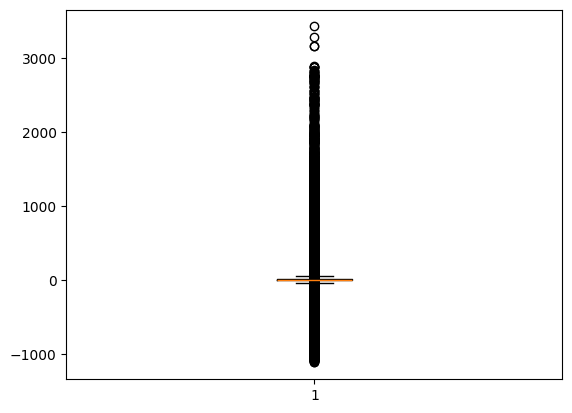

In [519]:
plt.boxplot(df_option_data['C_MID']-df_option_data['C_LAST'])
plt.show()

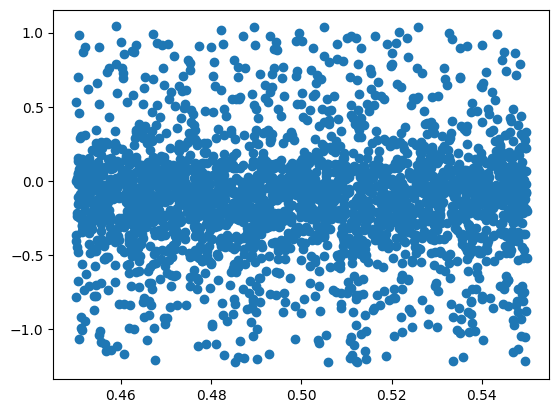

In [559]:
#i=len(df_quote_dates)-21*36
i=0
training_period = df_quote_dates.loc[i:i+21*36].values

plt.scatter(x=df_calls_diff.loc[training_period].xs('3M',level='Expiry_Bucket').xs(.5,level='BS_Delta_Bucket').C_DELTA_t1.to_numpy(),
            y=df_calls_diff.loc[training_period].xs('3M',level='Expiry_Bucket').xs(.5,level='BS_Delta_Bucket').y.to_numpy())

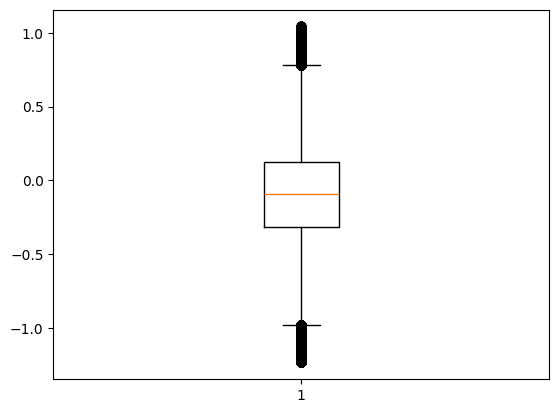

In [443]:
plt.boxplot(df_calls_diff.y.values)
plt.show()

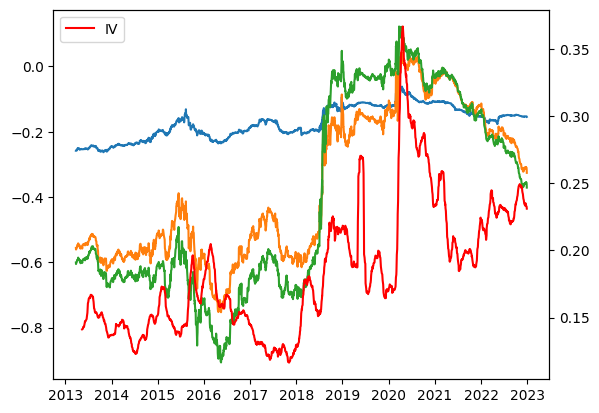

In [525]:
expiry_bucket = '6M'

fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(df_params.xs(expiry_bucket,level=1).index,
         df_params.xs(expiry_bucket,level=1)[['a','b','c']]*[1,-1,1]
         )


ax2.plot(df_calls_diff.xs('6M', level='Expiry_Bucket').loc[df_params.index.get_level_values(0).min():].groupby('QUOTE_DATE_t1').C_IV_t0.mean().rolling(30).mean(),
         label='IV',
         color='r')

plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

### Assesing Gains

In [571]:
def sse_bs(df_option_prices, expiry_bucket, delta_bucket):

    df = (df_option_prices
          .xs(delta_bucket,level='BS_Delta_Bucket')
          .xs(expiry_bucket, level='Expiry_Bucket'))
    
    epsilon_bs = df.delta_price - df.C_DELTA_t1*df.delta_S

    return sum(epsilon_bs**2)


def sse_mv(df_option_prices, df_params, expiry_bucket, delta_bucket):

    df = (df_option_prices
          .xs(delta_bucket,level='BS_Delta_Bucket')
          .xs(expiry_bucket, level='Expiry_Bucket'))
    
    a,b,c = df_params.loc[expiry_bucket,['a','b','c']]
    
    epsilon_bs = df.delta_price - df.C_DELTA_t1*df.delta_S
    epsilon_mv = epsilon_bs - (((df.C_VEGA_t1*100)*df.delta_S)/(np.sqrt(df.DTE_t1/360)*df.UNDERLYING_LAST_t1))*(a+b*df.C_DELTA_t1 + c*(df.C_DELTA_t1**2))


    return sum(epsilon_mv**2)


def gain_mv(df_option_prices, df_params, expiry_bucket, delta_bucket):

    _sse_bs = sse_bs(df_option_prices, expiry_bucket, delta_bucket)
    _sse_mv = sse_mv(df_option_prices, df_params, expiry_bucket, delta_bucket)

    return 1-_sse_mv/_sse_bs

In [560]:
i=0
training_period = df_quote_dates.loc[i:i+21*36].values
testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

In [568]:
df_params.loc[testing_period[0]]

,a,b,c,start_testing
expiry_bucket,,,,
1M,-0.228508,0.535961,-0.452283,2010-01-04
3M,-0.232177,0.462139,-0.46664,2010-01-04
6M,-0.258256,0.55594,-0.600934,2010-01-04
9M,-0.280989,0.600971,-0.721987,2010-01-04
12M,-0.277399,0.641813,-0.82839,2010-01-04


In [578]:
sse_bs(df_calls_diff.loc[testing_period[1:]],'6M',.5)

86.80437565410338

In [579]:
sse_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],'6M',.5)

45.86514506071337

In [587]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],'6M',.5)

0.4716263470003399

In [600]:
testing_period[1:]

array(['2013-03-26T00:00:00.000000000', '2013-03-27T00:00:00.000000000',
       '2013-03-28T00:00:00.000000000', '2013-04-01T00:00:00.000000000',
       '2013-04-02T00:00:00.000000000', '2013-04-03T00:00:00.000000000',
       '2013-04-04T00:00:00.000000000', '2013-04-05T00:00:00.000000000',
       '2013-04-08T00:00:00.000000000', '2013-04-09T00:00:00.000000000',
       '2013-04-10T00:00:00.000000000', '2013-04-11T00:00:00.000000000',
       '2013-04-12T00:00:00.000000000', '2013-04-15T00:00:00.000000000',
       '2013-04-16T00:00:00.000000000', '2013-04-17T00:00:00.000000000',
       '2013-04-18T00:00:00.000000000', '2013-04-19T00:00:00.000000000',
       '2013-04-22T00:00:00.000000000', '2013-04-23T00:00:00.000000000',
       '2013-04-24T00:00:00.000000000', '2013-04-25T00:00:00.000000000',
       '2013-04-26T00:00:00.000000000', '2013-04-29T00:00:00.000000000',
       '2013-04-30T00:00:00.000000000', '2013-05-01T00:00:00.000000000',
       '2013-05-02T00:00:00.000000000', '2013-05-03

In [ ]:
lists = [
   df_quote_dates.loc[21*36:].values,
   df_calls_diff.index.get_level_values(2).unique().categories
   
]

df_params = pd.DataFrame(columns=['a','b','c'],
                         index=pd.MultiIndex.from_tuples(itertools.product(*lists)))

df_params.index.names = ['end_testing', 'expiry_bucket']

df_params['start_testing'] = df_params.index.get_level_values(0).map(
    {end:start for 
     end,start in 
     zip(df_quote_dates.loc[21*36:].values, df_quote_dates.loc[:].values)})

In [607]:
df_calls_diff.index.get_level_values(1).unique()

Index([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.1, 0.3, 0.2], dtype='float64', name='BS_Delta_Bucket')

In [611]:
lists = [
   df_quote_dates.loc[21*36+1:].values,
   df_calls_diff.index.get_level_values(1).unique()
   ]


df_gain_mv = pd.DataFrame(index=pd.MultiIndex.from_tuples(itertools.product(*lists)),
                          columns=df_calls_diff.index.get_level_values(2).unique().categories)

df_gain_mv.index.names = ['start_testing','delta_bucket']
df_gain_mv

1M   3M   6M   9M  12M
start_testing delta_bucket                         
2013-03-26    0.9           NaN  NaN  NaN  NaN  NaN
              0.8           NaN  NaN  NaN  NaN  NaN
              0.7           NaN  NaN  NaN  NaN  NaN
              0.6           NaN  NaN  NaN  NaN  NaN
              0.5           NaN  NaN  NaN  NaN  NaN
...                         ...  ...  ...  ...  ...
2022-12-29    0.5           NaN  NaN  NaN  NaN  NaN
              0.4           NaN  NaN  NaN  NaN  NaN
              0.1           NaN  NaN  NaN  NaN  NaN
              0.3           NaN  NaN  NaN  NaN  NaN
              0.2           NaN  NaN  NaN  NaN  NaN

[21357 rows x 5 columns]

In [ ]:
i=0
testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

In [604]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],
       '6M',
       .5)

0.4716263470003399

In [616]:
df_gain_mv.loc[testing_period[1]].columns

Index(['1M', '3M', '6M', '9M', '12M'], dtype='object')

In [628]:
for delta in df_gain_mv.loc[testing_period[1]].index:

    for expiry in df_gain_mv.loc[testing_period[1]].columns:


        try:
            df_gain_mv.loc[testing_period[1], delta][expiry] = gain_mv(df_calls_diff.loc[testing_period[1:]],
                                                            df_params.loc[testing_period[0]],
                                                            expiry,
                                                            delta)
        except:
            
            pass

In [629]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
                                                            df_params.loc[testing_period[0]],
                                                            '6M',
                                                            .3)

0.6419263869507814

In [625]:
df_gain_mv.loc[testing_period[1], delta][expiry]

0.6990913632095656

In [630]:
df_gain_mv.head(10)

1M        3M        6M        9M       12M
start_testing delta_bucket                                                  
2013-03-26    0.9           0.266005  0.305617 -1.096795  0.580962   0.59693
              0.8           0.233891  0.371562 -2.191218  0.628194  0.622662
              0.7           0.230716  0.339784  0.564279  0.545132  0.546032
              0.6            0.19293  0.022859  0.430707  0.543685  0.496463
              0.5           0.152814  0.229107  0.471626  0.584716  0.370675
              0.4           0.287587  0.400225  0.395767  0.525398   0.45221
              0.1           0.666615  0.834353 -0.871553  0.400417  0.400417
              0.3           0.280547  0.420713  0.641926  0.674665 -2.071834
              0.2           0.640848  0.605943  0.447442  0.699091  0.699091
2013-03-27    0.9                NaN       NaN       NaN       NaN       NaN

In [588]:
1-45.86514506071337/86.80437565410338

0.4716263470003399

In [343]:
def sse_helio(params, df_option_prices, expiry_bucket):

    a = params[0]
    b = params[1]
    c = params[2]

    df = df_option_prices.xs(expiry_bucket,level='Expiry_Bucket')
    df = df.groupby(['BS_Delta_Bucket'])[['delta_S', 'delta_price', 'UNDERLYING_LAST_t1', 'C_VEGA_t1', 'DTE_t1']].mean()

    print(len(df))

    epsilon_bs = df['delta_price'] - df.index*df['delta_S']
    epsilon_mv = epsilon_bs - (df['C_VEGA_t1']*100*df['delta_S']/(df['UNDERLYING_LAST_t1']*np.sqrt(df.DTE_t1/360)))*(a+b*df.index+c*(df.index**2))

    return sum(epsilon_mv**2)


for i in range(0, len(df_quote_dates)-21*36):

    testing_period = df_quote_dates.loc[i:i+21*36].values
    training_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

    for expiry in df_params.loc[testing_period[-1]].index:

        result = minimize(fun=sse_helio,
            x0=np.array([0, 0, 0]),
            args=(df_calls_diff.loc[testing_period], expiry),
            method='SLSQP',
            )

        df_params.loc[testing_period[-1]].loc[expiry,['a','b','c']] = result.x

    print(testing_period[-1])



In [501]:
df_params

a         b         c start_testing
end_testing expiry_bucket                                            
2013-03-25  1M            -0.228508  0.535961 -0.452283    2010-01-04
            3M            -0.232177  0.462139  -0.46664    2010-01-04
            6M            -0.258256   0.55594 -0.600934    2010-01-04
            9M            -0.280989  0.600971 -0.721987    2010-01-04
            12M           -0.277399  0.641813  -0.82839    2010-01-04
...                             ...       ...       ...           ...
2022-12-29  1M            -0.138054  0.226451 -0.213137    2019-11-22
            3M            -0.141861  0.259235 -0.299518    2019-11-22
            6M            -0.154429  0.325992 -0.371271    2019-11-22
            9M            -0.198123  0.626323 -0.686782    2019-11-22
            12M           -0.231518  0.808532 -0.850201    2019-11-22

[11870 rows x 4 columns]

In [480]:
df_calls_diff.loc['2018-4-01':'2019-6-01']

UNDERLYING_LAST_t1  DTE_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                               
2018-04-02    0.7             1M                        2581.58    16.0   
                              1M                        2581.58    16.0   
                              1M                        2581.58    16.0   
              0.6             1M                        2581.58    16.0   
                              1M                        2581.58    16.0   
...                                                         ...     ...   
2019-05-31    0.5             9M                        2751.75   294.0   
                              9M                        2751.75   294.0   
              0.4             9M                        2751.75   294.0   
              0.3             12M                       2751.75   385.0   
                              12M                       2751.75   385.0   

                                             C_DELTA_t1  C_VEGA_t1  C_IV_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                   
2018-04-02    0.7             1M                0.74646    1.76531  0.27100   
                              1M                0.67949    1.97890  0.25858   
                              1M                0.66752    2.00983  0.25645   
              0.6             1M                0.64272    2.06309  0.24868   
                              1M                0.62917    2.09163  0.24788   
...                                                 ...        ...      ...   
2019-05-31    0.5             9M                0.50294    9.71136  0.19015   
                              9M                0.45480    9.66625  0.18144   
              0.4             9M                0.40380    9.46071  0.17326   
              0.3             12M               0.30231    9.74273  0.16005   
                              12M               0.27887    9.39917  0.15705   

                                             C_LAST_t1  C_MID_t1     C_BS_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2018-04-02    0.7             1M                100.10   114.855  118.416575   
                              1M                 78.50    91.650   94.946711   
                              1M                 86.10    87.950   91.194036   
              0.6             1M                 77.69    80.050   83.149669   
                              1M                 75.45    76.900   79.822544   
...                                                ...       ...         ...   
2019-05-31    0.5             9M                169.60   168.100  189.226276   
                              9M                138.90   139.200  158.266641   
              0.4             9M                116.10   112.360  130.010060   
              0.3             12M                82.00    79.345   97.764506   
                              12M                74.00    70.150   87.649809   

                                             UNDERLYING_LAST_t0  DTE_t0  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                               
2018-04-02    0.7             1M                        2614.43    15.0   
                              1M                        2614.43    15.0   
                              1M                        2614.43    15.0   
              0.6             1M                        2614.43    15.0   
                              1M                        2614.43    15.0   
...                                                         ...     ...   
2019-05-31    0.5             9M                        2743.80   291.0   
                              9M                        2743.80   291.0   
              0.4             9M                        2743.80   291.0   
              0.3             12M                       2743.80   382.0   
                              12M                       2743.80   382.0   

                        

In [ ]:
plt.plot(df_params.xs('3M',level=1)[['a','b','c']])
plt.show()

In [ ]:
df_params.loc[testing_period[-1]].loc['3M'] = result.x

In [ ]:
def sse_mv(params, df_option_prices, expiry_bucket):

    a = params[0]
    b = params[1]
    c = params[2]

    df = df_option_prices.xs(expiry_bucket,level='Expiry_Bucket')

    epsilon_bs = df['delta_price_perc'] - df['C_DELTA_t1']*df['delta_S_perc']
    epsilon_mv = epsilon_bs - (df['C_VEGA_t1']*100*df['delta_S_perc']/(np.sqrt(df.DTE_t1/360)))*(a+b*df['C_DELTA_t1']+c*(df['C_DELTA_t1']**2))

    return sum(epsilon_mv**2)


result = minimize(fun=sse_mv,
         x0=np.array([0, 0, 0]),
         args=(df_calls_diff.loc[testing_period], '3M'),
         method='SLSQP',
         )

print(result)

In [ ]:
a,b,c = result.x

x = df_calls_diff.loc[df_calls_diff.QUOTE_DATE_t0 == df_calls_diff.QUOTE_DATE_t0.max()].xs('6M',level='Expiry_Bucket').C_DELTA_t0
y = df_calls_diff.loc[df_calls_diff.QUOTE_DATE_t0 == df_calls_diff.QUOTE_DATE_t0.max()].xs('6M',level='Expiry_Bucket').apply(lambda row: row.C_VEGA_t0*100/(row.UNDERLYING_LAST_t0*np.sqrt(row.DTE_t0/360))*(a+b*row.C_DELTA_t0+c*(row.C_DELTA_t0**2)) ,axis=1)
plt.scatter(x=x,y=y)

In [ ]:
a,b,c = result.x

In [ ]:
x = [a+b*x+c*(x**2) for x in df_calls_diff.C_DELTA_t1]*df_calls_diff.delta_S_perc/(np.sqrt(df_calls_diff.DTE_t1/360))
y = df_calls_diff['C_IV_t0'] - df_calls_diff['C_IV_t1']


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data,c='black')

plt.show()

print(f"""Linear Regression - Change in Implied vs Normalized Return: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
plt.boxplot((df_helio['C_IV_t0']-df_helio['C_IV_t1']))
plt.show()

In [ ]:
#Parse data for CALLS

df_calls_data = df_option_data.drop(['P_BID', 'P_ASK', 'P_SIZE', 'P_LAST', 'P_DELTA', 
                                     'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV','P_VOLUME'], axis=1)

df_calls_data = df_calls_data[(df_calls_data.C_DELTA < .95)&(df_calls_data.C_DELTA > .05)]
df_calls_data['BS_Delta_Bucket'] = [round(x*10)/10 for x in df_calls_data.C_DELTA]

df_calls_data['Expiry_Bucket'] = pd.cut(df_calls_data.DTE,[14,30,91, 182,365,2000],
                                        labels=['1M', '3M', '6M', '9M', '12M'])

#df_calls_data = df_calls_data.set_index(['BS_Delta_Bucket','Expiry_Bucket'])

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df_calls_data.set_index(['EXPIRE_UNIX'])

In [ ]:
df_foo = df_calls_data.set_index(['BS_Delta_Bucket','Expiry_Bucket']).loc[(.5,'6M')]

df_foo = df_foo.groupby('QUOTE_DATE')[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE','C_MID','C_BS']].mean()

df_foo['Delta_S'] = df_foo['UNDERLYING_LAST'].diff()/df_foo['UNDERLYING_LAST']
df_foo['Delta_IV'] = df_foo['C_IV'].diff()

df_foo = df_foo.dropna()

x = df_foo['Delta_IV']
y = df_foo['Delta_S']

slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Asset Price vs Change in Implied Vol: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

x = (df_foo['UNDERLYING_LAST'].diff()*df_foo['C_DELTA']).dropna()
y = df_foo['C_BS'].diff().dropna()


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Option Price vs PnL Delta: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
pd.to_datetime('2010-01-08')-pd.to_datetime('2010-04-15')

In [ ]:
df_calls_data.iloc[1000]


In [ ]:
black_scholes(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
              K=df_calls_data.iloc[1000].STRIKE,
              sigma=df_calls_data.iloc[1000].C_IV,
              T=df_calls_data.iloc[1000].DTE/360,
              r=-0.01)

In [ ]:
bs_delta(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
         K=df_calls_data.iloc[1000].STRIKE,
         sigma=df_calls_data.iloc[1000].C_IV,
         T=df_calls_data.iloc[1000].DTE/360,
         r=-0.01)

In [ ]:
bs_vega(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
              K=df_calls_data.iloc[1000].STRIKE,
              sigma=df_calls_data.iloc[1000].C_IV,
              T=df_calls_data.iloc[1000].DTE/360,
              r=-0.01)

In [ ]:
df_calls_data = df_calls_data.groupby(['Expiry_Bucket','QUOTE_DATE','BS_Delta_Bucket'])[['UNDERLYING_LAST', 'C_IV', 'C_MID', 'C_DELTA', 'C_VEGA', 'DTE']].mean().copy()
df_calls_data = df_calls_data.dropna()

In [ ]:
df_calls_data

In [ ]:
df_calls_data.index.get_level_values(0).unique().to_list()

In [ ]:
def sse(params):

    total_sse = 0.0

    a = params[0]
    b = params[1]
    c = params[2]

    for expiry in df_calls_data.index.get_level_values(0).unique().to_list():

        delta_f = df_calls_data.xs(expiry).groupby(level=1)['C_MID'].diff()
        delta_s = df_calls_data.xs(expiry).groupby(level=1)['UNDERLYING_LAST'].diff()
        delta_bs = df_calls_data.xs(expiry).groupby(level=1).diff().index.get_level_values(1)
        vega_bs = df_calls_data.xs(expiry)['C_VEGA']*100
        dte = df_calls_data.xs(expiry)['DTE']/360
        underlying = df_calls_data.xs(expiry)['UNDERLYING_LAST']
        
        error_bs = delta_f - delta_bs*delta_s
        error_mv = error_bs - (vega_bs*delta_s/(np.sqrt(dte)*underlying))*(a + b*delta_bs + c*(delta_bs**2))
        error_mv = error_mv.dropna()
    
        total_sse += sum(error_mv**2)
    
    return total_sse


In [ ]:
sse(np.array([0,0,0]))

In [ ]:
df_foo2 = df_calls_data.xs('6M', level=1)

df_foo2 = df_foo2.groupby(['BS_Delta_Bucket','QUOTE_DATE'])[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE']].mean()

list_slopes = []

for delta_bucket in df_foo2.index.get_level_values(0).unique():

    df_loop = df_foo2.loc[delta_bucket]
    df_loop['Delta_S'] = df_loop['UNDERLYING_LAST'].diff()/df_loop['UNDERLYING_LAST']
    
    df_loop['Delta_IV'] = df_loop['C_IV'].diff()

    df_loop = df_loop.dropna()

    x = df_loop['Delta_IV']
    y = df_loop['Delta_S']

    slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
    fitted_data = list(map(fitted_line, x))

    # plt.scatter(x = df_loop['Delta_IV'],
    #             y = df_loop['Delta_S'])

    # plt.plot(x, fitted_data)

    # plt.show()
    list_slopes.append(slope)
    # print(f"""Linear Regression - Log Std Deviation of Prices vs Log Simulations: \n
    #     Slope:{slope}\n
    #     Intercept:{intercept}\n  
    #     R²: {r**2}""")
    
    # print(delta_bucket)


In [ ]:
df_foo2 = df_foo2.reset_index().sort_values(['QUOTE_DATE','BS_Delta_Bucket']).set_index(['QUOTE_DATE','BS_Delta_Bucket'])
quote_dates = df_foo2.index.get_level_values(0).unique()

In [ ]:
def epsilon_mv(df_t0, df_t1, a, b, c):

    available_deltas = list(set(df_t0.index).intersection(df_t1.index))
    df_t0 = df_t0.loc[available_deltas]
    df_t1 = df_t1.loc[available_deltas]

    epsilon_bs = (df_t0.C_LAST-df_t1.C_LAST) - df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)
    epsilon_mv = epsilon_bs - ((df_t1.C_VEGA*100*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))
    return epsilon_mv

In [ ]:
epsilon_mv_total = []

for i in range(len(quote_dates)-1):

    epsilon_mv_total.append(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=0,b=0,c=0).to_list())

SSE = sum([sum(np.array(error)**2) for error in epsilon_mv_total])
print(np.sqrt(SSE))

In [ ]:
quote_dates[i]

In [ ]:
np.sqrt(sum([sum(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=0,b=0,c=0)**2) for i in range(len(quote_dates)-1)]))

In [ ]:
    
def sse_mv(params):

    a = params[0]
    b = params[1]
    c= params[2]

    epsilon_mv_total = []

    for i in range(len(quote_dates)-1):

        epsilon_mv_total.append(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=a,b=b,c=c).to_list())

    return sum([sum(np.array(error)**2) for error in epsilon_mv_total])

In [ ]:
result = minimize(fun=sse,
         x0=np.array([0, 0, 0]),
         method='Nelder-Mead',
         )

print(result)

In [ ]:
np.sqrt(sse_mv(result.x))

In [ ]:
df_calls_data

In [ ]:
a,b,c = result.x

y = df_calls_data.xs('2012-12-31',level=1).xs('9M', level=0)
plt.scatter(x=y.index,y=y.index + y.C_VEGA*10/(y.UNDERLYING_LAST*np.sqrt(y.DTE/360))*(a+b*y.index+c*(y.index**2)))

In [ ]:
(y.C_VEGA/(y.UNDERLYING_LAST*np.sqrt(y.DTE/360))*(a+b*y.index+c*(y.index**2)))

In [ ]:
c*(y.index**2)

In [ ]:
y = df_option_data.iloc[28364]
print(y.head(20))
print(black_scholes(S=y.UNDERLYING_LAST,K=y.STRIKE,sigma=y.C_IV,T=y.DTE/360,r=0.0))
bs_delta(S=y.UNDERLYING_LAST,K=y.STRIKE,sigma=y.C_IV,T=y.DTE/360,r=0)

In [ ]:
np.sqrt(sse_mv(np.array([-0.2,.4,-.5])))

In [ ]:
np.sqrt(sse(np.array([-3.090e+00, 1.269e+01, -1.925e+01])))

In [ ]:
# for prettier numpy prints
np.set_printoptions(precision = 6)

In [ ]:
sse(np.array([0,0,0]))

In [ ]:
np.sqrt(sse(result.x))

In [ ]:
call

In [ ]:
result.x

In [ ]:
np.sqrt(sse([0,0,0]))

In [ ]:
df_calls_data

In [ ]:
[i/np.sqrt(360) for i in [-3.400e+00 ,1.478e+01, -2.341e+01]]

In [ ]:
quote_dates

In [ ]:
df_foo2.loc[quote_dates[i-1]].index

In [ ]:
list(set(df_foo2.loc[quote_dates[i-1]].index).intersection(df_foo2.loc[quote_dates[i]].index))

In [ ]:
sum(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=-.0,b=0,c=0)**2)

In [ ]:
epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=-.05,b=0,c=-.6).to_list()

In [ ]:
quote_dates[i-1]

In [ ]:
df_t0

In [ ]:
a,b,c=0,0,0
i=30
df_t0 = df_foo2.loc[quote_dates[i]]
df_t1 = df_foo2.loc[quote_dates[i-1]]

available_deltas = list(set(df_t0.index).intersection(df_t1.index))
df_t0 = df_t0.loc[available_deltas]
df_t1 = df_t1.loc[available_deltas]

epsilon_bs = (df_t0.C_LAST-df_t1.C_LAST) - df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)
epsilon_mv = epsilon_bs - ((df_t1.C_VEGA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))

In [ ]:
(df_t0.C_LAST-df_t1.C_LAST)

In [ ]:
df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)

In [ ]:
sum(epsilon_bs**2)

In [ ]:
a=.0
((df_t1.C_VEGA*100*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))

In [ ]:
df_t0.UNDERLYING_LAST

In [ ]:
df_foo2.loc[quote_dates[i-1]]

In [ ]:
df_foo2.loc[quote_dates[i],['C_LAST', 'C_BID', 'C_ASK']]

In [ ]:
plt.plot((df_foo2.loc['2010-01-05'].C_LAST-df_foo2.loc['2010-01-06'].C_LAST)-(df_foo2.loc['2010-01-05'].UNDERLYING_LAST-df_foo2.loc['2010-01-06'].UNDERLYING_LAST)*df_foo2.loc['2010-01-05'].C_DELTA)

In [ ]:
df_foo2.index.get_level_values(0).unique()

In [ ]:
list_slopes = np.sqrt(df_foo2.groupby('BS_Delta_Bucket')['DTE'].mean().values/360)*list_slopes

x = df_foo2.index.get_level_values(0).unique()
y = list_slopes

model = np.poly1d(np.polyfit(x, y, 2))

#add fitted polynomial line to scatterplot
plt.scatter(x, y)
plt.plot(x, model(x))

print(model)
plt.show()



In [ ]:
for i in df_foo2.index.get_level_values(0).unique():

    df_foo2.loc[i]

In [ ]:
df_foo2.loc[.5].C_LAST.diff().plot()

In [ ]:
plt.plot(df_foo2.loc[i].C_DELTA)

In [ ]:
i=.5
plt.plot(df_foo2.loc[i].UNDERLYING_LAST.diff()*df_foo2.loc[i].C_DELTA)
plt.plot(df_foo2.loc[i].C_LAST.diff())

In [ ]:
df_foo2.loc[i].C_LAST.diff()

In [ ]:
y

#### $ \Delta f - \delta_{bs}\Delta S = \frac{\nu_{bs}}{\sqrt{T}}\frac{\Delta S}{S}(a+b\delta_{bs}+\delta^{2}_{bs}) $

In [ ]:
df_foo2.loc[i,'UNDERLYING_LAST'].diff()*df_foo2.loc[i,'C_VEGA']/(np.sqrt(df_foo2.loc[i,'DTE'])*df_foo2.loc[i,'UNDERLYING_LAST'])

In [ ]:
x = (df_foo2.loc[i]['UNDERLYING_LAST'].diff()*df_foo2.loc[i]['C_DELTA']).dropna()
y = df_foo2.loc[i]['C_LAST'].diff().dropna()


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Option Price vs PnL Delta: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

data = (x-y).values
bins = 30

bins = np.histogram(data, 
                    bins=30)[1]

bins = [float(x) for x in bins]


fig, ax = plt.subplots(figsize=(25,16))

sns.histplot(data,stat='density',
                bins=30,
                ax=ax)

sns.lineplot(ax=ax,
             x=bins,
             y=gaussian(data=data,
                        bins=bins),
            color='red')


textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(data), ),
    r'$\mathrm{median}=%.2f$' % (np.median(data), ),
    r'$\sigma=%.2f$' % (np.std(data), ),
    r'$\frac{\sigma}{\mu}=%.2f$'% (np.std(data)*100/np.mean(data), )+'%'))

ax.text(0.1, 0.95, textstr, 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            bbox=props)

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

data = (x).values
bins = 30

bins = np.histogram(data, 
                    bins=30)[1]

bins = [float(x) for x in bins]


fig, ax = plt.subplots(figsize=(25,16))

sns.histplot(data,stat='density',
                bins=30,
                ax=ax)

sns.lineplot(ax=ax,
             x=bins,
             y=gaussian(data=data,
                        bins=bins),
            color='red')


textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(data), ),
    r'$\mathrm{median}=%.2f$' % (np.median(data), ),
    r'$\sigma=%.2f$' % (np.std(data), ),
    r'$\frac{\sigma}{\mu}=%.2f$'% (np.std(data)*100/np.mean(data), )+'%'))

ax.text(0.1, 0.95, textstr, 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            bbox=props)